In my previous exploration I worked with a few indiviaual models like KNN, NaiveBayes and DescionTrees.  Since then we were introduced to ensemble and neural network modeling.  I will explore here an ensemble approach to determine if bett results can be obtained.

And after revisiting the results I noticed the DecicionTree model is performing the best.

I will use the BaggingClassifier, RandomForestClassifier and the AdaBoostClassifier as presented in module 21.
Also, althout not presented in class, I'll look at another ensemble model found in scikit learn called IsolationForest.  The data given is about anomoly detection and this model sounded like its intended for data sets with a large feature size.

I know from previous exploration the best KNN, DT and NB model parameters to use.  So from here we can explore how using that as the base estimator changes the outcome of the performance.

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, IsolationForest

import warnings
warnings.filterwarnings('ignore') 


In [88]:
train_df = pd.read_csv('data/Train.csv')

In [89]:
test_df = pd.read_csv('data/Test.csv')

In [90]:
sub_df = pd.read_csv('data/Sample_submission.csv')

In [91]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763 entries, 0 to 1762
Columns: 1559 entries, feature_1 to Class
dtypes: float64(1), int64(1558)
memory usage: 21.0 MB


In [92]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 1558 entries, feature_1 to feature_1558
dtypes: float64(4), int64(1554)
memory usage: 9.0 MB


In [93]:
train_df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
0,100,160,1.6000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,20,83,4.1500,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,99,150,1.5151,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40,40,1.0000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,234,19.5000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
sub_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Class   756 non-null    float64
dtypes: float64(1)
memory usage: 6.0 KB


In [95]:
sub_df.value_counts()

Class
0.0      756
dtype: int64

In [96]:
train_df['Class'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1763 entries, 0 to 1762
Series name: Class
Non-Null Count  Dtype
--------------  -----
1763 non-null   int64
dtypes: int64(1)
memory usage: 13.9 KB


In [97]:
train_df['Class'].value_counts()

0    1620
1     143
Name: Class, dtype: int64

In [98]:
# Check the anomoly rate classification
train_df[train_df['Class'] == 1.0].shape[0] / train_df.shape[0]

0.08111174134997164

In [99]:
test_df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_1549,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558
0,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,108.0,179.0,1.6574,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1.0,2.0000,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,60.0,120.0,2.0000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [100]:
train_df_drop = train_df.transpose().drop_duplicates().transpose()
train_df_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763 entries, 0 to 1762
Columns: 730 entries, feature_1 to Class
dtypes: float64(730)
memory usage: 9.8 MB


In [101]:
X = train_df_drop.drop('Class', axis=1)
y = train_df_drop['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y)

Instantiate the models from previous exploration.

In [102]:
dt = DecisionTreeClassifier(random_state=42, max_depth=2)
knn = KNeighborsClassifier(n_neighbors=50)
mnb = MultinomialNB(alpha=200)

In [103]:
 def execute_model(name, mdl, scale=True):
    if (scale):
        pipe = Pipeline([('scaler', StandardScaler()), ('model', mdl)])
    else:
        pipe = Pipeline([('model', mdl)])

    pipe.fit(X_train, y_train)
    score = pipe.score(X_test, y_test)
    preds = pipe.predict(X_test)
    cm = confusion_matrix(y_test, preds, labels=pipe['model'].classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe['model'].classes_)
    fig, ax = plt.subplots(figsize=(8,6))
    ax.set(title=name)
    disp.plot(ax = ax)
    return score

In [104]:
def grid_search(name, mdl, params, scale=True, scoring=None, cv=5):
    if (scale):
        pipe = Pipeline([('scaler', StandardScaler()),  
                         ('model', mdl)])
    else:
        pipe = Pipeline([ ('model', mdl)])

    grid = GridSearchCV(pipe, param_grid=params, verbose=3, scoring=scoring, cv=cv)
    #grid.fit(X_train, y_train)
    #score = grid.score(X_test, y_test)
    #preds = grid.predict(X_test)
    grid.fit(X_train, y_train)
    score = grid.score(X_test, y_test)
    preds = grid.predict(X_test)
    pipe = grid.best_estimator_
    print(pipe)
    print(grid.best_params_)
    #cm = confusion_matrix(y_test, preds, labels=pipe['model'].classes_)
    cm = confusion_matrix(y_test, preds, labels=pipe['model'].classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe['model'].classes_)
    fig, ax = plt.subplots(figsize=(8,6))
    ax.set(title=name + ' ' + str(grid.best_params_) + str(scoring))
    disp.plot(ax = ax)
    return score, str(grid.best_params_)

Bagging Classifier

Try out some base models to be sure they work.

Then use grid search to find optimal model settings.

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.925 total time=   0.3s
[CV 2/5] END model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.906 total time=   0.2s
[CV 3/5] END model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.913 total time=   0.2s
[CV 4/5] END model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.905 total time=   0.2s
[CV 5/5] END model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.886 total time=   0.2s
[CV 1/5] END model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=20;, score=0.925 total time=   0.6s
[CV 2/5] END model__bootstrap=Fa

[CV 1/5] END model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.909 total time=   0.3s
[CV 2/5] END model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.891 total time=   0.3s
[CV 3/5] END model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.909 total time=   0.3s
[CV 4/5] END model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.890 total time=   0.3s
[CV 5/5] END model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.886 total time=   0.3s
[CV 1/5] END model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=20;, score=0.921 total time=   0.6s
[CV 2/5] END model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model_

[CV 1/5] END model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 2/5] END model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 3/5] END model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=5;, score=0.920 total time=   0.0s
[CV 4/5] END model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 5/5] END model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 1/5] END model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.902 total time=   0.1s
[CV 2/5] END model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimat

[CV 3/5] END model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=5;, score=0.920 total time=   0.0s
[CV 4/5] END model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 5/5] END model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 1/5] END model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.909 total time=   0.1s
[CV 2/5] END model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.928 total time=   0.1s
[CV 3/5] END model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.905 total time=   0.1s
[CV 4/5] END model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimat

[CV 5/5] END model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
Pipeline(steps=[('model',
                 BaggingClassifier(max_features=0.1, n_estimators=5,
                                   random_state=42))])
{'model__bootstrap': True, 'model__bootstrap_features': False, 'model__max_features': 0.1, 'model__n_estimators': 5}


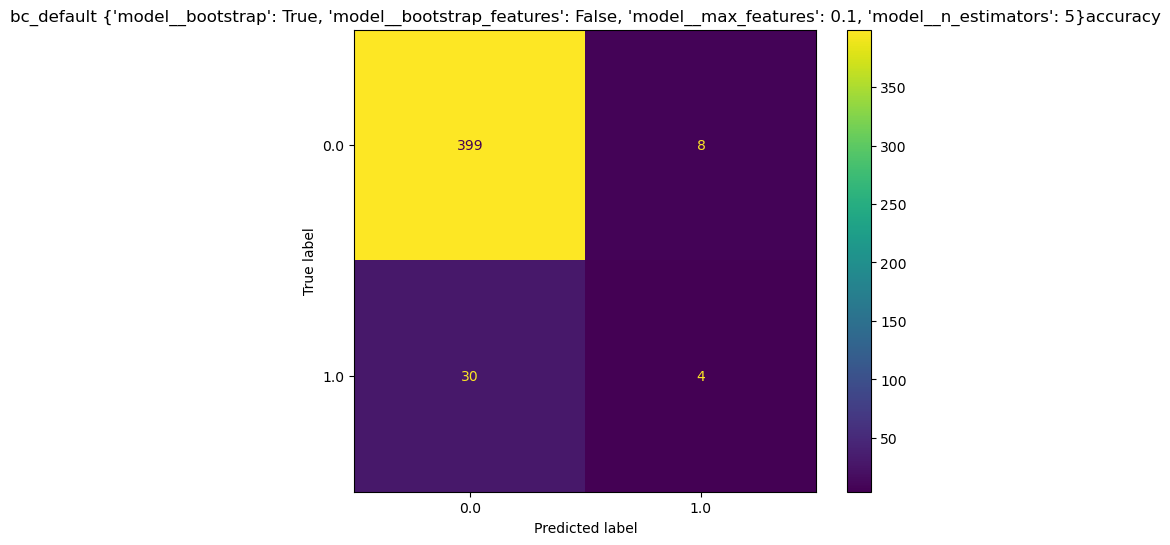

In [105]:
# Test grid search
bc_params = { 'model__bootstrap' : [False, True],
              'model__bootstrap_features' : [False, True],
              'model__max_features' : [1.0, 0.5, 0.1, 10],
              'model__n_estimators' : [10, 20, 5]
            }
bc_default = BaggingClassifier(random_state=42)
score, best = grid_search('bc_default', bc_default, bc_params, scale=False, scoring='accuracy', cv=5)

In [106]:
# Setup the various base estimators
bc_params = { 'model__bootstrap' : [False, True],
              'model__bootstrap_features' : [False, True],
              'model__max_features' : [1.0, 0.5, 0.1, 10],
              'model__n_estimators' : [10, 20, 5],
              'model__base_estimator' : [None, dt, knn, mnb]
            }

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV 1/5] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.545 total time=   0.2s
[CV 2/5] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.273 total time=   0.2s
[CV 3/5] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.333 total time=   0.2s
[CV 4/5] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.318 total time=   0.2s
[CV 5/5] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.364 total time=   0.2s
[CV 1/5] END model__base_estimator=None, m

[CV 1/5] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 2/5] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 3/5] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 4/5] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 5/5] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 1/5] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_f

[CV 3/5] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.095 total time=   0.0s
[CV 4/5] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.091 total time=   0.0s
[CV 5/5] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.182 total time=   0.0s
[CV 1/5] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=5;, score=0.227 total time=   0.0s
[CV 2/5] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=5;, score=0.227 total time=   0.0s
[CV 3/5] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_feat

[CV 5/5] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.318 total time=   0.1s
[CV 1/5] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=5;, score=0.318 total time=   0.0s
[CV 2/5] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=5;, score=0.364 total time=   0.0s
[CV 3/5] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=5;, score=0.286 total time=   0.0s
[CV 4/5] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=5;, score=0.500 total time=   0.0s
[CV 5/5] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_featur

[CV 2/5] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.364 total time=   0.0s
[CV 3/5] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.476 total time=   0.0s
[CV 4/5] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.182 total time=   0.0s
[CV 5/5] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.455 total time=   0.0s
[CV 1/5] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.182 total time=   0.1s
[CV 2/5] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5

[CV 1/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.455 total time=   0.0s
[CV 2/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.182 total time=   0.0s
[CV 3/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.381 total time=   0.0s
[CV 4/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.318 total time=   0.0s
[CV 5/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), mod

[CV 3/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.190 total time=   0.0s
[CV 4/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 5/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.136 total time=   0.0s
[CV 1/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=5;, score=0.091 total time=   0.0s
[CV 2/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), mode

[CV 5/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.318 total time=   0.0s
[CV 1/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.318 total time=   0.0s
[CV 2/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.182 total time=   0.0s
[CV 3/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.286 total time=   0.0s
[CV 4/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__b

[CV 5/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 1/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.318 total time=   0.0s
[CV 2/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.182 total time=   0.0s
[CV 3/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.333 total time=   0.0s
[CV 4/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bo

[CV 4/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.045 total time=   0.0s
[CV 5/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.136 total time=   0.0s
[CV 1/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 2/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 3/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bo

[CV 3/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.143 total time=   0.0s
[CV 4/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.091 total time=   0.0s
[CV 5/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.045 total time=   0.0s
[CV 1/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=20;, score=0.227 total time=   0.0s
[CV 2/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__boot

[CV 1/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.000 total time=   0.1s
[CV 2/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.000 total time=   0.1s
[CV 3/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.000 total time=   0.1s
[CV 4/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.000 total time=   0.1s
[CV 5/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, m

[CV 5/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.000 total time=   0.1s
[CV 1/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 2/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 3/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 4/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, mode

[CV 1/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=20;, score=0.000 total time=   0.2s
[CV 2/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=20;, score=0.000 total time=   0.2s
[CV 3/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=20;, score=0.000 total time=   0.2s
[CV 4/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=20;, score=0.000 total time=   0.2s
[CV 5/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model_

[CV 2/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.000 total time=   0.1s
[CV 3/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.000 total time=   0.1s
[CV 4/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.000 total time=   0.1s
[CV 5/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.091 total time=   0.1s
[CV 1/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model_

[CV 5/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 1/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 2/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 3/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 4/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_es

[CV 5/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=20;, score=0.000 total time=   0.2s
[CV 1/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 2/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 3/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 4/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estim

[CV 2/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=20;, score=0.045 total time=   0.0s
[CV 3/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=20;, score=0.048 total time=   0.0s
[CV 4/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=20;, score=0.091 total time=   0.0s
[CV 5/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=20;, score=0.045 total time=   0.0s
[CV 1/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.091 total time=   0.0s
[CV 2/

[CV 1/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 2/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 3/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 4/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 5/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 1/5] E

[CV 5/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 1/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 2/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 3/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 4/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 5/5] E

[CV 4/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=10;, score=0.045 total time=   0.0s
[CV 5/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 1/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.045 total time=   0.0s
[CV 2/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 3/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.048 total time=   0.0s
[CV 4/5] E

[CV 3/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.048 total time=   0.0s
[CV 4/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.091 total time=   0.0s
[CV 5/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.045 total time=   0.0s
[CV 1/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=20;, score=0.045 total time=   0.0s
[CV 2/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=20;, score=0.045 total time=   0.0s
[CV 3/5] END mo

[CV 5/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 1/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 2/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 3/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 4/5] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 5/5] END model__

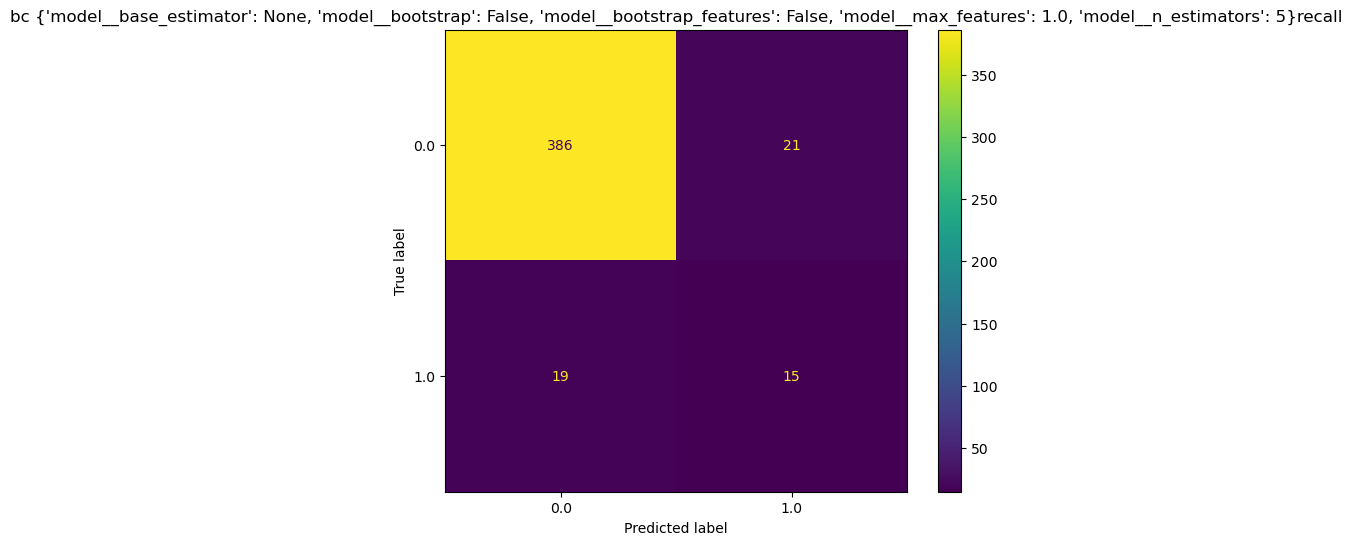

In [107]:
# This will take awhile.
bc = BaggingClassifier(random_state=42)
score, best = grid_search('bc', bc, bc_params, scale=False, scoring='recall', cv=5)

Random Forest Classifier

Use grid search to find optimal model settings.
It doesn't appear to have configurable base estimator.

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END model__max_depth=None, model__min_samples_split=2, model__n_estimators=5;, score=0.871 total time=   0.0s
[CV 2/5] END model__max_depth=None, model__min_samples_split=2, model__n_estimators=5;, score=0.762 total time=   0.0s
[CV 3/5] END model__max_depth=None, model__min_samples_split=2, model__n_estimators=5;, score=0.787 total time=   0.0s
[CV 4/5] END model__max_depth=None, model__min_samples_split=2, model__n_estimators=5;, score=0.784 total time=   0.0s
[CV 5/5] END model__max_depth=None, model__min_samples_split=2, model__n_estimators=5;, score=0.846 total time=   0.0s
[CV 1/5] END model__max_depth=None, model__min_samples_split=2, model__n_estimators=10;, score=0.867 total time=   0.0s
[CV 2/5] END model__max_depth=None, model__min_samples_split=2, model__n_estimators=10;, score=0.830 total time=   0.0s
[CV 3/5] END model__max_depth=None, model__min_samples_split=2, model__n_estimators=10;, score=0.897 to

[CV 5/5] END model__max_depth=10, model__min_samples_split=2, model__n_estimators=10;, score=0.856 total time=   0.0s
[CV 1/5] END model__max_depth=10, model__min_samples_split=2, model__n_estimators=100;, score=0.936 total time=   0.1s
[CV 2/5] END model__max_depth=10, model__min_samples_split=2, model__n_estimators=100;, score=0.925 total time=   0.1s
[CV 3/5] END model__max_depth=10, model__min_samples_split=2, model__n_estimators=100;, score=0.932 total time=   0.1s
[CV 4/5] END model__max_depth=10, model__min_samples_split=2, model__n_estimators=100;, score=0.913 total time=   0.0s
[CV 5/5] END model__max_depth=10, model__min_samples_split=2, model__n_estimators=100;, score=0.886 total time=   0.1s
[CV 1/5] END model__max_depth=10, model__min_samples_split=2, model__n_estimators=200;, score=0.938 total time=   0.2s
[CV 2/5] END model__max_depth=10, model__min_samples_split=2, model__n_estimators=200;, score=0.931 total time=   0.2s
[CV 3/5] END model__max_depth=10, model__min_samp

[CV 5/5] END model__max_depth=100, model__min_samples_split=2, model__n_estimators=200;, score=0.886 total time=   0.4s
[CV 1/5] END model__max_depth=100, model__min_samples_split=4, model__n_estimators=5;, score=0.891 total time=   0.0s
[CV 2/5] END model__max_depth=100, model__min_samples_split=4, model__n_estimators=5;, score=0.895 total time=   0.0s
[CV 3/5] END model__max_depth=100, model__min_samples_split=4, model__n_estimators=5;, score=0.873 total time=   0.0s
[CV 4/5] END model__max_depth=100, model__min_samples_split=4, model__n_estimators=5;, score=0.764 total time=   0.0s
[CV 5/5] END model__max_depth=100, model__min_samples_split=4, model__n_estimators=5;, score=0.839 total time=   0.0s
[CV 1/5] END model__max_depth=100, model__min_samples_split=4, model__n_estimators=10;, score=0.912 total time=   0.0s
[CV 2/5] END model__max_depth=100, model__min_samples_split=4, model__n_estimators=10;, score=0.884 total time=   0.0s
[CV 3/5] END model__max_depth=100, model__min_sample

[CV 1/5] END model__max_depth=200, model__min_samples_split=4, model__n_estimators=100;, score=0.897 total time=   0.1s
[CV 2/5] END model__max_depth=200, model__min_samples_split=4, model__n_estimators=100;, score=0.916 total time=   0.1s
[CV 3/5] END model__max_depth=200, model__min_samples_split=4, model__n_estimators=100;, score=0.891 total time=   0.1s
[CV 4/5] END model__max_depth=200, model__min_samples_split=4, model__n_estimators=100;, score=0.886 total time=   0.2s
[CV 5/5] END model__max_depth=200, model__min_samples_split=4, model__n_estimators=100;, score=0.887 total time=   0.1s
[CV 1/5] END model__max_depth=200, model__min_samples_split=4, model__n_estimators=200;, score=0.928 total time=   0.4s
[CV 2/5] END model__max_depth=200, model__min_samples_split=4, model__n_estimators=200;, score=0.915 total time=   0.4s
[CV 3/5] END model__max_depth=200, model__min_samples_split=4, model__n_estimators=200;, score=0.906 total time=   0.4s
[CV 4/5] END model__max_depth=200, model

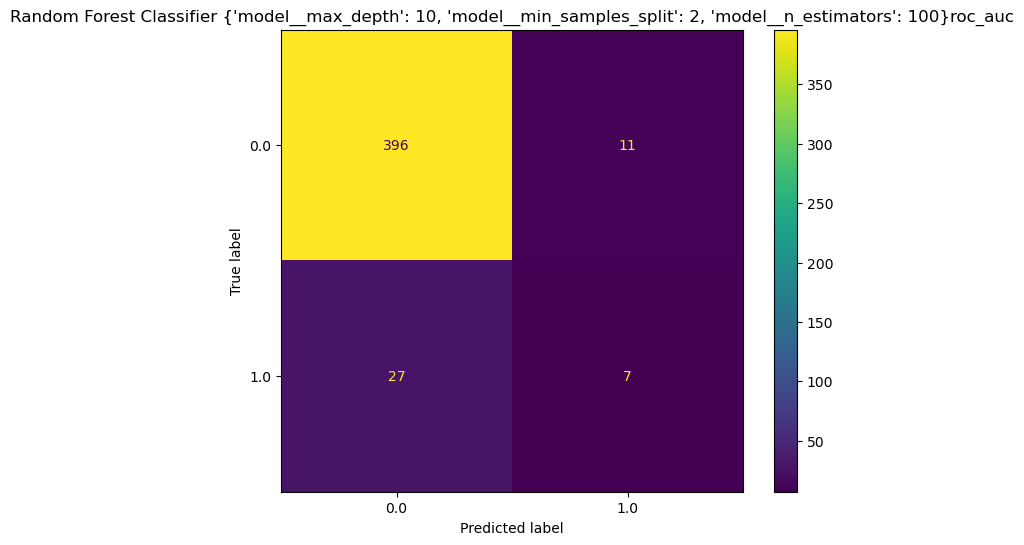

In [108]:
# Try a default RandomForestClassifier
rfc_params = { 'model__n_estimators' : [5, 10, 100, 200],
               'model__max_depth' : [None, 10, 100, 200],
               'model__min_samples_split' : [2, 4, 6]
             }
rfc = RandomForestClassifier(random_state=42)
score, best = grid_search('Random Forest Classifier', rfc, rfc_params, scale=False, scoring='roc_auc', cv=5)

AdaBoost Classifier

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5] END model__base_estimator=None, model__learning_rate=0.1, model__n_estimators=5;, score=0.882 total time=   0.0s
[CV 2/5] END model__base_estimator=None, model__learning_rate=0.1, model__n_estimators=5;, score=0.756 total time=   0.0s
[CV 3/5] END model__base_estimator=None, model__learning_rate=0.1, model__n_estimators=5;, score=0.890 total time=   0.0s
[CV 4/5] END model__base_estimator=None, model__learning_rate=0.1, model__n_estimators=5;, score=0.825 total time=   0.0s
[CV 5/5] END model__base_estimator=None, model__learning_rate=0.1, model__n_estimators=5;, score=0.829 total time=   0.0s
[CV 1/5] END model__base_estimator=None, model__learning_rate=0.1, model__n_estimators=10;, score=0.873 total time=   0.0s
[CV 2/5] END model__base_estimator=None, model__learning_rate=0.1, model__n_estimators=10;, score=0.841 total time=   0.0s
[CV 3/5] END model__base_estimator=None, model__learning_rate=0.1, model__n_estima

[CV 2/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__learning_rate=0.1, model__n_estimators=10;, score=0.802 total time=   0.0s
[CV 3/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__learning_rate=0.1, model__n_estimators=10;, score=0.823 total time=   0.0s
[CV 4/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__learning_rate=0.1, model__n_estimators=10;, score=0.775 total time=   0.0s
[CV 5/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__learning_rate=0.1, model__n_estimators=10;, score=0.848 total time=   0.0s
[CV 1/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__learning_rate=0.1, model__n_estimators=20;, score=0.869 total time=   0.1s
[CV 2/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__learning_rate=0.1, model__n_estimators=20;, score

[CV 3/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__learning_rate=100.0, model__n_estimators=20;, score=0.742 total time=   0.0s
[CV 4/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__learning_rate=100.0, model__n_estimators=20;, score=0.830 total time=   0.0s
[CV 5/5] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__learning_rate=100.0, model__n_estimators=20;, score=0.754 total time=   0.0s
[CV 1/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__learning_rate=0.1, model__n_estimators=5;, score=nan total time=   0.0s
[CV 2/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__learning_rate=0.1, model__n_estimators=5;, score=nan total time=   0.0s
[CV 3/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__learning_rate=0.1, model__n_estimators=5;, score=nan total time=   0.0s
[CV 4/5] END model__base_

[CV 4/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__learning_rate=100.0, model__n_estimators=20;, score=nan total time=   0.0s
[CV 5/5] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__learning_rate=100.0, model__n_estimators=20;, score=nan total time=   0.0s
[CV 1/5] END model__base_estimator=MultinomialNB(alpha=200), model__learning_rate=0.1, model__n_estimators=5;, score=0.531 total time=   0.0s
[CV 2/5] END model__base_estimator=MultinomialNB(alpha=200), model__learning_rate=0.1, model__n_estimators=5;, score=0.388 total time=   0.0s
[CV 3/5] END model__base_estimator=MultinomialNB(alpha=200), model__learning_rate=0.1, model__n_estimators=5;, score=0.419 total time=   0.0s
[CV 4/5] END model__base_estimator=MultinomialNB(alpha=200), model__learning_rate=0.1, model__n_estimators=5;, score=0.418 total time=   0.0s
[CV 5/5] END model__base_estimator=MultinomialNB(alpha=200), model__learning_rate=0.1, model__n_estimators=5;, score=0.381

[CV 2/5] END model__base_estimator=MultinomialNB(alpha=200), model__learning_rate=100.0, model__n_estimators=20;, score=0.388 total time=   0.0s
[CV 3/5] END model__base_estimator=MultinomialNB(alpha=200), model__learning_rate=100.0, model__n_estimators=20;, score=0.418 total time=   0.0s
[CV 4/5] END model__base_estimator=MultinomialNB(alpha=200), model__learning_rate=100.0, model__n_estimators=20;, score=0.413 total time=   0.0s
[CV 5/5] END model__base_estimator=MultinomialNB(alpha=200), model__learning_rate=100.0, model__n_estimators=20;, score=0.381 total time=   0.0s
Pipeline(steps=[('model',
                 AdaBoostClassifier(learning_rate=0.1, n_estimators=10,
                                    random_state=42))])
{'model__base_estimator': None, 'model__learning_rate': 0.1, 'model__n_estimators': 10}


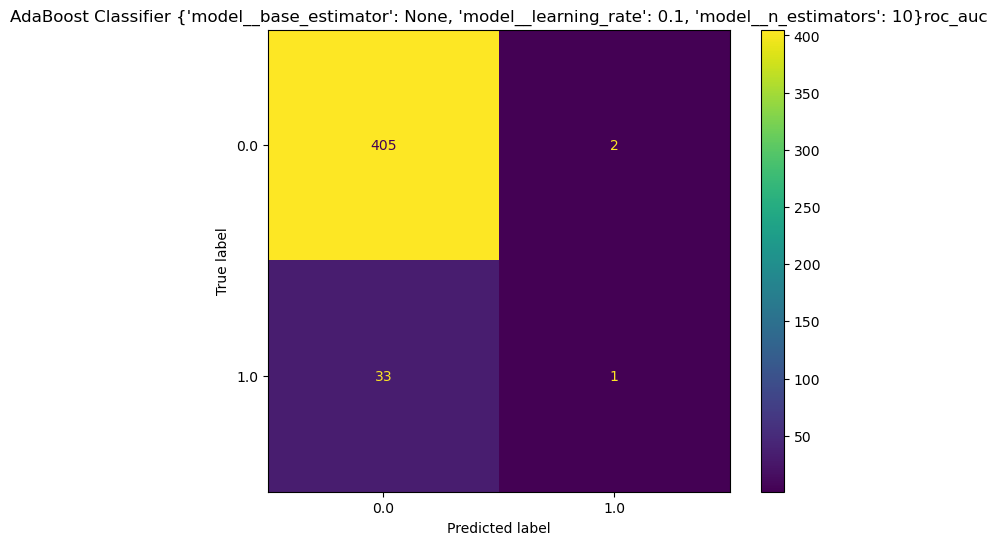

In [109]:
abc_params = { 'model__learning_rate' : [0.1, 1.0, 10.0, 100.0],
               'model__n_estimators' : [5, 10, 20],
               'model__base_estimator' : [None, dt, knn, mnb]
            }
abc = AdaBoostClassifier(random_state=42)
score, best = grid_search('AdaBoost Classifier', abc, abc_params, scale=False, scoring='roc_auc', cv=5)



In [110]:
# Try to find the best of the best
results = []
results2 = []
model_names = ['Bagging', 'RandomForest', 'AdaBoost']
scoring = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc', 'neg_mean_squared_error']
models = [bc, rfc, abc]
params = [bc_params, rfc_params, abc_params]
scale = [False, False, False, False]


Fitting 10 folds for each of 192 candidates, totalling 1920 fits
[CV 1/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.902 total time=   0.3s
[CV 2/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.932 total time=   0.4s
[CV 3/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.902 total time=   0.3s
[CV 4/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.917 total time=   0.3s
[CV 5/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.917 total time=   0.3s
[CV 6/10] END model__base_estimator

[CV 7/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.902 total time=   0.4s
[CV 8/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.894 total time=   0.3s
[CV 9/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.902 total time=   0.4s
[CV 10/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.886 total time=   0.3s
[CV 1/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=5;, score=0.910 total time=   0.0s
[CV 2/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, m

[CV 4/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 5/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 6/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 7/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 8/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 9/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model_

[CV 10/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=20;, score=0.902 total time=   0.8s
[CV 1/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.902 total time=   0.2s
[CV 2/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.940 total time=   0.1s
[CV 3/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.917 total time=   0.1s
[CV 4/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.902 total time=   0.1s
[CV 5/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max

[CV 7/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=10;, score=0.924 total time=   0.0s
[CV 8/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=10;, score=0.909 total time=   0.0s
[CV 9/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=10;, score=0.924 total time=   0.0s
[CV 10/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=10;, score=0.909 total time=   0.0s
[CV 1/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.917 total time=   0.0s
[CV 2/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model_

[CV 10/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 1/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.910 total time=   0.1s
[CV 2/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.932 total time=   0.1s
[CV 3/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.909 total time=   0.1s
[CV 4/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.909 total time=   0.1s
[CV 5/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__m

[CV 6/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.924 total time=   0.2s
[CV 7/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.902 total time=   0.2s
[CV 8/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.894 total time=   0.2s
[CV 9/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.909 total time=   0.2s
[CV 10/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.894 total time=   0.2s
[CV 1/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model_

[CV 6/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 7/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 8/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 9/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 10/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 1/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_

[CV 4/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 5/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.939 total time=   0.0s
[CV 6/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.894 total time=   0.0s
[CV 7/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.879 total time=   0.0s
[CV 8/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.909 total time=   0.0s
[CV 9/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_feature

[CV 2/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.910 total time=   0.0s
[CV 3/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.909 total time=   0.0s
[CV 4/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.924 total time=   0.0s
[CV 5/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.924 total time=   0.0s
[CV 6/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.917 total time=   0.0s
[CV 7/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_fe

[CV 10/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 1/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 2/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.955 total time=   0.0s
[CV 3/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.902 total time=   0.0s
[CV 4/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features

[CV 10/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=10;, score=0.902 total time=   0.0s
[CV 1/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.925 total time=   0.0s
[CV 2/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.932 total time=   0.0s
[CV 3/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.902 total time=   0.0s
[CV 4/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42

[CV 7/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.917 total time=   0.0s
[CV 8/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.909 total time=   0.0s
[CV 9/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.932 total time=   0.0s
[CV 10/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.917 total time=   0.0s
[CV 1/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42

[CV 9/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 10/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 1/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.925 total time=   0.0s
[CV 2/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.940 total time=   0.0s
[CV 3/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), mod

[CV 7/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.932 total time=   0.0s
[CV 8/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.924 total time=   0.0s
[CV 9/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.939 total time=   0.0s
[CV 10/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.909 total time=   0.0s
[CV 1/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), m

[CV 4/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.924 total time=   0.0s
[CV 5/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.909 total time=   0.0s
[CV 6/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.909 total time=   0.0s
[CV 7/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.917 total time=   0.0s
[CV 8/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), mo

[CV 6/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 7/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 8/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 9/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 10/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bo

[CV 6/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=10;, score=0.924 total time=   0.0s
[CV 7/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=10;, score=0.932 total time=   0.0s
[CV 8/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=10;, score=0.909 total time=   0.0s
[CV 9/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=10;, score=0.939 total time=   0.0s
[CV 10/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), m

[CV 6/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.909 total time=   0.0s
[CV 7/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.924 total time=   0.0s
[CV 8/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.917 total time=   0.0s
[CV 9/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.932 total time=   0.0s
[CV 10/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), m

[CV 4/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 5/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 6/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 7/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 8/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__boo

[CV 1/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.925 total time=   0.0s
[CV 2/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 3/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.902 total time=   0.0s
[CV 4/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.924 total time=   0.0s
[CV 5/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model_

[CV 10/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=10;, score=0.924 total time=   0.0s
[CV 1/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.925 total time=   0.0s
[CV 2/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.925 total time=   0.0s
[CV 3/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.902 total time=   0.0s
[CV 4/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model

[CV 6/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 7/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 8/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 9/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 10/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootst

[CV 6/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 7/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 8/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 9/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 10/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=

[CV 6/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.917 total time=   0.1s
[CV 7/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.917 total time=   0.0s
[CV 8/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.917 total time=   0.0s
[CV 9/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.917 total time=   0.0s
[CV 10/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=

[CV 7/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 8/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 9/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 10/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 1/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, mode

[CV 6/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 7/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 8/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 9/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 10/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, 

[CV 5/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.917 total time=   0.0s
[CV 6/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.917 total time=   0.0s
[CV 7/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.917 total time=   0.0s
[CV 8/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.917 total time=   0.1s
[CV 9/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, m

[CV 5/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 6/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 7/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 8/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 9/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_e

[CV 4/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=10;, score=0.924 total time=   0.0s
[CV 5/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=10;, score=0.909 total time=   0.0s
[CV 6/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 7/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 8/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, m

[CV 4/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.917 total time=   0.1s
[CV 5/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.917 total time=   0.1s
[CV 6/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.917 total time=   0.1s
[CV 7/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.917 total time=   0.1s
[CV 8/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, m

[CV 6/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 7/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 8/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 9/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 10/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_

[CV 7/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.917 total time=   0.1s
[CV 8/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 9/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 10/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 1/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model

[CV 8/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.917 total time=   0.1s
[CV 9/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.917 total time=   0.1s
[CV 10/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.917 total time=   0.1s
[CV 1/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 2/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model_

[CV 1/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.925 total time=   0.0s
[CV 2/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.910 total time=   0.0s
[CV 3/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.924 total time=   0.0s
[CV 4/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 5/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.924 total time=   0.0s


[CV 5/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.924 total time=   0.0s
[CV 6/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.917 total time=   0.0s
[CV 7/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.917 total time=   0.0s
[CV 8/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.932 total time=   0.0s
[CV 9/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.917 total time=   0.0s


[CV 7/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 8/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 9/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 10/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 1/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.917 total time=   0.0s
[CV 

[CV 9/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=20;, score=0.924 total time=   0.0s
[CV 10/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=20;, score=0.894 total time=   0.0s
[CV 1/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.910 total time=   0.0s
[CV 2/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.895 total time=   0.0s
[CV 3/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 4/1

[CV 9/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 10/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 1/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.917 total time=   0.0s
[CV 2/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.917 total time=   0.0s
[CV 3/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.924 total time=   0.0s
[CV 

[CV 9/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 10/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 1/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.925 total time=   0.0s
[CV 2/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.910 total time=   0.0s
[CV 3/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.924 total time=   0.0s
[CV 4/10

[CV 2/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.910 total time=   0.0s
[CV 3/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.924 total time=   0.0s
[CV 4/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.917 total time=   0.0s
[CV 5/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.924 total time=   0.0s
[CV 6/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.917 total time=   0.0s
[CV 7

[CV 8/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 9/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 10/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 1/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 2/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 3/10]

[CV 2/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=20;, score=0.910 total time=   0.0s
[CV 3/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=20;, score=0.932 total time=   0.0s
[CV 4/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=20;, score=0.924 total time=   0.0s
[CV 5/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=20;, score=0.924 total time=   0.0s
[CV 6/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=20;, score=0.917 total time=   0.0s
[CV 7/10] 

[CV 10/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=5;, score=0.909 total time=   0.0s
[CV 1/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 2/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 3/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=10;, score=0.924 total time=   0.0s
[CV 4/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=10;, score=0.917 total time=   0.0s
[CV 5/10] 

[CV 8/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.917 total time=   0.0s
[CV 9/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.917 total time=   0.0s
[CV 10/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.917 total time=   0.0s
[CV 1/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 2/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=5;, score=0.917 total time=   0.0s
[CV 3/10] END mo

[CV 10/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.545 total time=   0.1s
[CV 1/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=10;, score=0.364 total time=   0.1s
[CV 2/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=10;, score=0.273 total time=   0.1s
[CV 3/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=10;, score=0.500 total time=   0.1s
[CV 4/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=10;, score=0.182 total time=   0.1s
[CV 5/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, m

[CV 7/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.273 total time=   0.0s
[CV 8/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.091 total time=   0.0s
[CV 9/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.364 total time=   0.0s
[CV 10/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.182 total time=   0.0s
[CV 1/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 2/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, m

[CV 3/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.600 total time=   0.3s
[CV 4/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.182 total time=   0.3s
[CV 5/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.364 total time=   0.3s
[CV 6/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.364 total time=   0.3s
[CV 7/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.091 total time=   0.3s
[CV 8/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__

[CV 9/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=20;, score=0.273 total time=   0.4s
[CV 10/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=20;, score=0.273 total time=   0.4s
[CV 1/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=5;, score=0.273 total time=   0.0s
[CV 2/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=5;, score=0.545 total time=   0.1s
[CV 3/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=5;, score=0.300 total time=   0.0s
[CV 4/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__ma

[CV 9/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 10/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 1/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 2/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 3/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 4/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_

[CV 6/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.364 total time=   0.0s
[CV 7/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.273 total time=   0.0s
[CV 8/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.273 total time=   0.0s
[CV 9/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.545 total time=   0.0s
[CV 10/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.182 total time=   0.0s
[CV 1/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_

[CV 2/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.182 total time=   0.0s
[CV 3/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.300 total time=   0.0s
[CV 4/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.091 total time=   0.0s
[CV 5/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.364 total time=   0.0s
[CV 6/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.273 total time=   0.0s
[CV 7/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__

[CV 1/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.182 total time=   0.2s
[CV 2/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.364 total time=   0.2s
[CV 3/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.600 total time=   0.2s
[CV 4/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.182 total time=   0.1s
[CV 5/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.455 total time=   0.2s
[CV 6/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_fe

[CV 8/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=20;, score=0.182 total time=   0.2s
[CV 9/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=20;, score=0.364 total time=   0.2s
[CV 10/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=20;, score=0.273 total time=   0.2s
[CV 1/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=5;, score=0.182 total time=   0.0s
[CV 2/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=5;, score=0.545 total time=   0.0s
[CV 3/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_fea

[CV 1/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 2/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 3/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 4/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 5/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 6/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=True, model__max_feature

[CV 4/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.091 total time=   0.0s
[CV 5/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.273 total time=   0.0s
[CV 6/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.364 total time=   0.0s
[CV 7/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.273 total time=   0.0s
[CV 8/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), mo

[CV 10/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=5;, score=0.182 total time=   0.0s
[CV 1/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 2/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=10;, score=0.182 total time=   0.0s
[CV 3/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=10;, score=0.300 total time=   0.0s
[CV 4/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42)

[CV 3/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 4/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 5/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 6/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 7/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), mo

[CV 1/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.273 total time=   0.0s
[CV 2/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.636 total time=   0.0s
[CV 3/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.300 total time=   0.0s
[CV 4/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.091 total time=   0.0s
[CV 5/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model_

[CV 9/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=5;, score=0.273 total time=   0.0s
[CV 10/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=5;, score=0.182 total time=   0.0s
[CV 1/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=10;, score=0.091 total time=   0.0s
[CV 2/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=10;, score=0.182 total time=   0.0s
[CV 3/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), mod

[CV 1/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 2/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 3/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 4/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 5/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model_

[CV 8/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=20;, score=0.000 total time=   0.1s
[CV 9/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=20;, score=0.273 total time=   0.1s
[CV 10/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=20;, score=0.000 total time=   0.1s
[CV 1/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.182 total time=   0.0s
[CV 2/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), mo

[CV 8/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=5;, score=0.273 total time=   0.0s
[CV 9/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=5;, score=0.364 total time=   0.0s
[CV 10/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=5;, score=0.182 total time=   0.0s
[CV 1/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 2/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), mode

[CV 3/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 4/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 5/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 6/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 7/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model_

[CV 10/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=20;, score=0.182 total time=   0.1s
[CV 1/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.273 total time=   0.0s
[CV 2/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.636 total time=   0.0s
[CV 3/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.300 total time=   0.0s
[CV 4/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__b

[CV 8/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=5;, score=0.364 total time=   0.0s
[CV 9/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=5;, score=0.273 total time=   0.0s
[CV 10/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=5;, score=0.182 total time=   0.0s
[CV 1/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 2/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__b

[CV 3/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 4/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 5/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 6/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 7/10] END model__base_estimator=DecisionTreeClassifier(max_depth=2, random_state=42), model__boo

[CV 3/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.100 total time=   0.0s
[CV 4/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.091 total time=   0.0s
[CV 5/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 6/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 7/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, 

[CV 2/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 3/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 4/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 5/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 6/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0

[CV 1/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 2/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 3/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.1s
[CV 4/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 5/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, m

[CV 10/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=20;, score=0.000 total time=   0.2s
[CV 1/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 2/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 3/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.100 total time=   0.0s
[CV 4/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, mod

[CV 1/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 2/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 3/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 4/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 5/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, m

[CV 2/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.1s
[CV 3/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 4/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 5/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.1s
[CV 6/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model_

[CV 3/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 4/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 5/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 6/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 7/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model

[CV 3/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 4/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 5/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 6/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 7/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, m

[CV 2/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.1s
[CV 3/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.1s
[CV 4/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.1s
[CV 5/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.1s
[CV 6/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model_

[CV 3/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.100 total time=   0.0s
[CV 4/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.091 total time=   0.0s
[CV 5/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.091 total time=   0.0s
[CV 6/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 7/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=1.0, model__n_e

[CV 4/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 5/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 6/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 7/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 8/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model_

[CV 5/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.1s
[CV 6/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.1s
[CV 7/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 8/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.1s
[CV 9/10] END model__base_estimator=KNeighborsClassifier(n_neighbors=50), model__bootstrap=True, model__bootstrap_features=True, model__max_features=10, model__n_es

[CV 7/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 8/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.182 total time=   0.0s
[CV 9/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.091 total time=   0.0s
[CV 10/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 1/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV

[CV 5/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 6/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 7/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 8/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 9/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=20;, score=0.000 total time=   0.0s


[CV 2/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.091 total time=   0.0s
[CV 3/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.100 total time=   0.0s
[CV 4/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.091 total time=   0.0s
[CV 5/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.091 total time=   0.0s
[CV 6/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 7

[CV 7/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 8/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=20;, score=0.091 total time=   0.0s
[CV 9/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 10/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 1/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 2

[CV 9/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 10/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 1/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 2/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 3/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 4/10]

[CV 3/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.100 total time=   0.0s
[CV 4/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 5/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.091 total time=   0.0s
[CV 6/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 7/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 8/10] 

[CV 6/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 7/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 8/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 9/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 10/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.1, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 

[CV 9/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 10/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 1/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 2/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 3/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 4/10] EN

[CV 5/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.091 total time=   0.0s
[CV 6/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 7/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 8/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.182 total time=   0.0s
[CV 9/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.5, model__n_estimators=10;, score=0.091 total time=   0.0s
[CV 10/10]

[CV 1/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 2/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 3/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 4/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 5/10] END model__base_estimator=MultinomialNB(alpha=200), model__bootstrap=True, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 6/10] END m

[CV 1/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.400 total time=   0.3s
[CV 2/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.600 total time=   0.3s
[CV 3/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.364 total time=   0.3s
[CV 4/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.500 total time=   0.2s
[CV 5/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.500 total time=   0.3s
[CV 6/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, m

[CV 7/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.250 total time=   0.4s
[CV 8/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.200 total time=   0.3s
[CV 9/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.417 total time=   0.3s
[CV 10/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.333 total time=   0.3s
[CV 1/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=5;, score=0.444 total time=   0.0s
[CV 2/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, m

[CV 8/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 9/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 10/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 1/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 2/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model__max_features=10, model__n_estimators=20;, score=0.000 total time=   0.0s
[CV 3/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=False, model

[CV 4/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.333 total time=   0.1s
[CV 5/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.500 total time=   0.1s
[CV 6/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.625 total time=   0.1s
[CV 7/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.167 total time=   0.1s
[CV 8/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=1.0, model__n_estimators=5;, score=0.429 total time=   0.1s
[CV 9/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_f

[CV 10/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=10;, score=0.400 total time=   0.1s
[CV 1/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.500 total time=   0.1s
[CV 2/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.400 total time=   0.1s
[CV 3/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.500 total time=   0.1s
[CV 4/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=0.1, model__n_estimators=20;, score=0.500 total time=   0.0s
[CV 5/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model_

[CV 10/10] END model__base_estimator=None, model__bootstrap=False, model__bootstrap_features=True, model__max_features=10, model__n_estimators=5;, score=0.000 total time=   0.0s
[CV 1/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.429 total time=   0.1s
[CV 2/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.625 total time=   0.2s
[CV 3/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.429 total time=   0.2s
[CV 4/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=1.0, model__n_estimators=10;, score=0.333 total time=   0.1s
[CV 5/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__m

[CV 6/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.556 total time=   0.2s
[CV 7/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.333 total time=   0.2s
[CV 8/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.286 total time=   0.2s
[CV 9/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.444 total time=   0.2s
[CV 10/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=0.5, model__n_estimators=20;, score=0.333 total time=   0.2s
[CV 1/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model_

[CV 5/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 6/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 7/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 8/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 9/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_features=10, model__n_estimators=10;, score=0.000 total time=   0.0s
[CV 10/10] END model__base_estimator=None, model__bootstrap=True, model__bootstrap_features=False, model__max_

KeyboardInterrupt: 

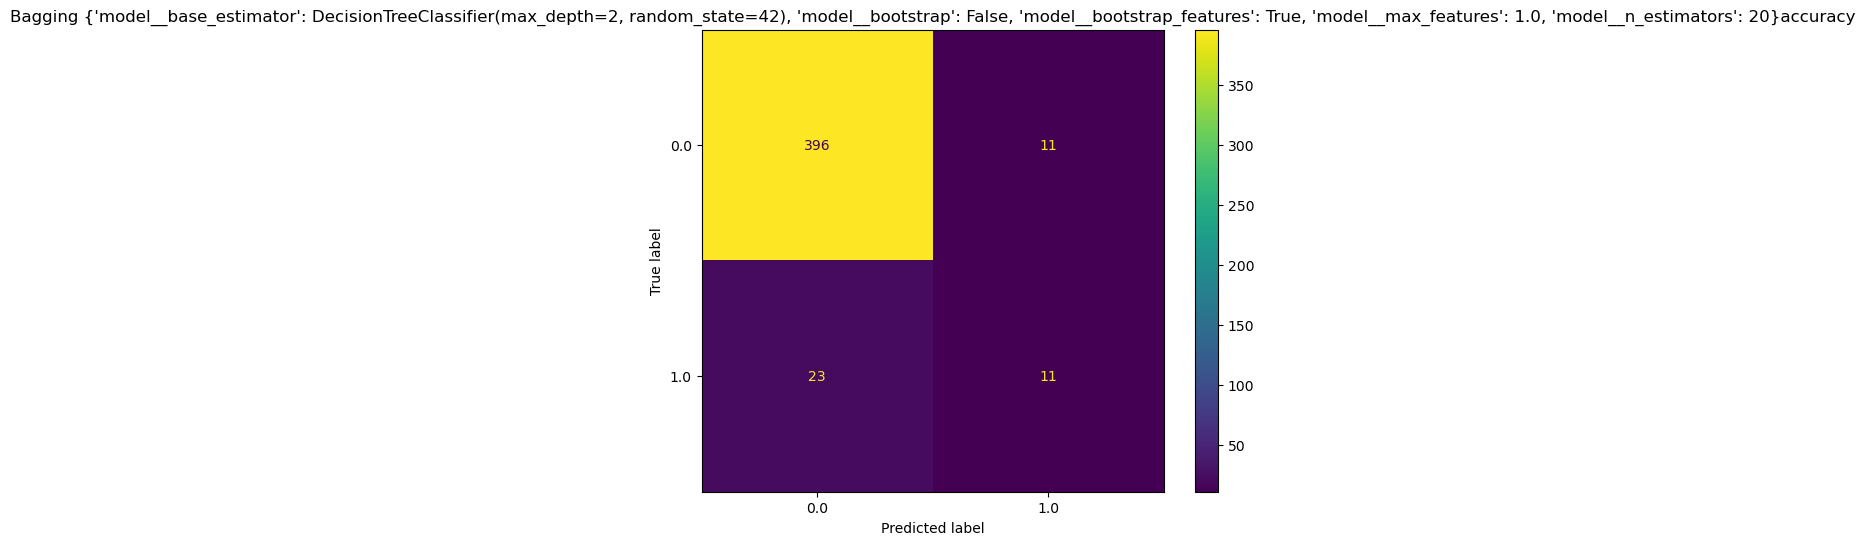

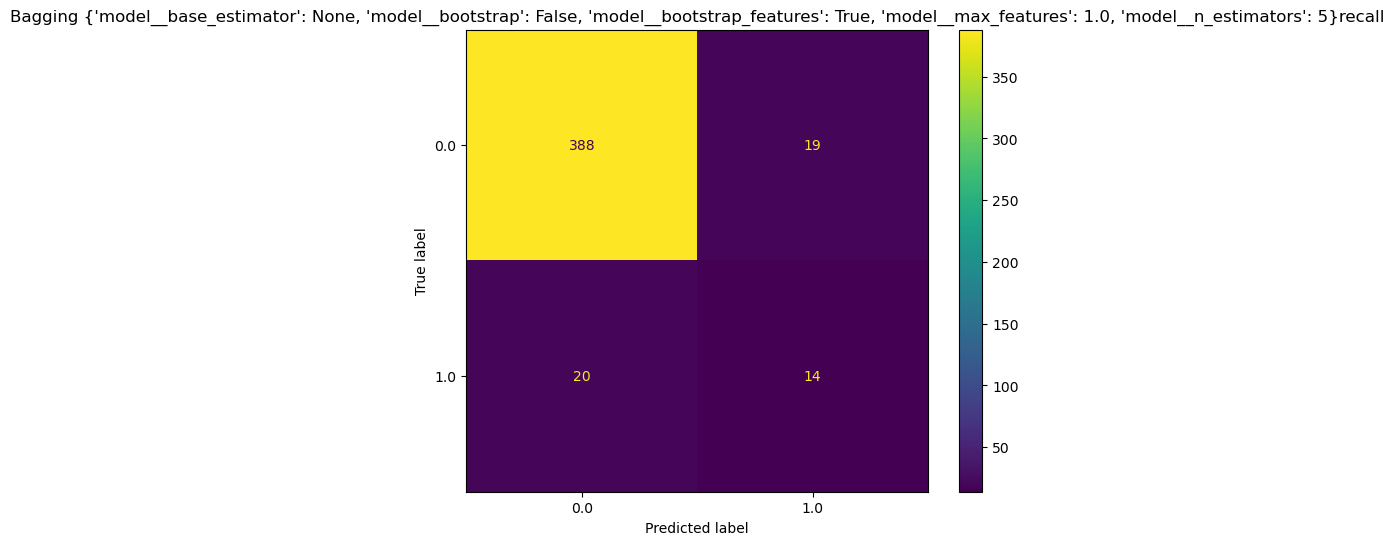

In [111]:
for j in range(len(model_names)):
    scores = ['model_name']
    best_params = ['model_name']
    for i in range(len(scoring)):
        score, best_param = grid_search(model_names[j], models[j], params[j], scale=scale[j], scoring=scoring[i], cv=10)
        scores.append(score)
        best_params.append(best_param)
    results.append(scores)
    results2.append(best_params)

In [ ]:
df1 = pd.DataFrame(results, columns=['Model'] + scoring)
df1['Model'] = model_names
df1

In [ ]:
df2 = pd.DataFrame(results2, columns=['Model'] + scoring)
df2['Model'] = model_names
df2

In [ ]:
pd.options.display.max_colwidth = 1000
print(df2[df2['Model'] == 'Bagging'])

In [ ]:
bc = BaggingClassifier(random_state=42, bootstrap=False, bootstrap_features=False, max_features=1.0, n_estimators=5)
score = execute_model('bc', bc, scale=False)
print(score)

In [ ]:
def select_feature(name, mdl, count=10, scale=True):
    if (scale):
        pipe = Pipeline([('scaler', StandardScaler()),  
                         ('selector', SequentialFeatureSelector(mdl, n_features_to_select=count)),
                         ('model', mdl)])
    else:
        pipe = Pipeline([ ('selector', SequentialFeatureSelector(mdl, n_features_to_select=count)),
                          ('model', mdl)])

    pipe.fit(X_train, y_train)
    score = pipe.score(X_test, y_test)
    preds = pipe.predict(X_test)
    sft = pipe['selector'].get_feature_names_out()
    print("Features:", sft)
    cm = confusion_matrix(y_test, preds, labels=pipe['model'].classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe['model'].classes_)
    fig, ax = plt.subplots(figsize=(8,6))
    ax.set(title=name)
    disp.plot(ax = ax)

In [ ]:
select_feature("bc", bc, count=10, scale=False)

In [ ]:
select_feature("bc", bc, count=20, scale=False)

In [ ]:
select_feature("bc", bc, count=40, scale=False)

Isolation Forest

In [134]:
def grid_search_iso(name, mdl, params, scale=True, scoring=None, cv=5):
    if (scale):
        pipe = Pipeline([('scaler', StandardScaler()),  
                         ('model', mdl)])
    else:
        pipe = Pipeline([ ('model', mdl)])

    grid = GridSearchCV(pipe, param_grid=params, verbose=3, scoring=scoring, cv=cv)
    grid.fit(X_train, y_train)
    
    return grid


In [135]:
ifm_params = { 'model__bootstrap' : [False, True],
              'model__max_features' : ['auto', 1.0, 0.5, 0.1],
              'model__max_samples' : [1.0, 0.5, 0.1],
              'model__n_estimators' : [10, 50, 100, 200],
            }
ifm = IsolationForest(random_state=42)

In [136]:
grid = grid_search_iso('Isolation Forest Classifier', ifm, ifm_params, scale=False, scoring='roc_auc', cv=5)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5] END model__bootstrap=False, model__max_features=auto, model__max_samples=1.0, model__n_estimators=10;, score=nan total time=   0.0s
[CV 2/5] END model__bootstrap=False, model__max_features=auto, model__max_samples=1.0, model__n_estimators=10;, score=nan total time=   0.0s
[CV 3/5] END model__bootstrap=False, model__max_features=auto, model__max_samples=1.0, model__n_estimators=10;, score=nan total time=   0.0s
[CV 4/5] END model__bootstrap=False, model__max_features=auto, model__max_samples=1.0, model__n_estimators=10;, score=nan total time=   0.0s
[CV 5/5] END model__bootstrap=False, model__max_features=auto, model__max_samples=1.0, model__n_estimators=10;, score=nan total time=   0.0s
[CV 1/5] END model__bootstrap=False, model__max_features=auto, model__max_samples=1.0, model__n_estimators=50;, score=nan total time=   0.0s
[CV 2/5] END model__bootstrap=False, model__max_features=auto, model__max_samples=1.0, model

[CV 3/5] END model__bootstrap=False, model__max_features=1.0, model__max_samples=1.0, model__n_estimators=10;, score=0.434 total time=   0.0s
[CV 4/5] END model__bootstrap=False, model__max_features=1.0, model__max_samples=1.0, model__n_estimators=10;, score=0.324 total time=   0.0s
[CV 5/5] END model__bootstrap=False, model__max_features=1.0, model__max_samples=1.0, model__n_estimators=10;, score=0.323 total time=   0.0s
[CV 1/5] END model__bootstrap=False, model__max_features=1.0, model__max_samples=1.0, model__n_estimators=50;, score=0.312 total time=   0.2s
[CV 2/5] END model__bootstrap=False, model__max_features=1.0, model__max_samples=1.0, model__n_estimators=50;, score=0.249 total time=   0.2s
[CV 3/5] END model__bootstrap=False, model__max_features=1.0, model__max_samples=1.0, model__n_estimators=50;, score=0.345 total time=   0.2s
[CV 4/5] END model__bootstrap=False, model__max_features=1.0, model__max_samples=1.0, model__n_estimators=50;, score=0.276 total time=   0.2s
[CV 5/

[CV 5/5] END model__bootstrap=False, model__max_features=0.5, model__max_samples=1.0, model__n_estimators=10;, score=0.368 total time=   0.0s
[CV 1/5] END model__bootstrap=False, model__max_features=0.5, model__max_samples=1.0, model__n_estimators=50;, score=0.199 total time=   0.1s
[CV 2/5] END model__bootstrap=False, model__max_features=0.5, model__max_samples=1.0, model__n_estimators=50;, score=0.226 total time=   0.1s
[CV 3/5] END model__bootstrap=False, model__max_features=0.5, model__max_samples=1.0, model__n_estimators=50;, score=0.335 total time=   0.1s
[CV 4/5] END model__bootstrap=False, model__max_features=0.5, model__max_samples=1.0, model__n_estimators=50;, score=0.238 total time=   0.1s
[CV 5/5] END model__bootstrap=False, model__max_features=0.5, model__max_samples=1.0, model__n_estimators=50;, score=0.266 total time=   0.1s
[CV 1/5] END model__bootstrap=False, model__max_features=0.5, model__max_samples=1.0, model__n_estimators=100;, score=0.195 total time=   0.2s
[CV 2

[CV 2/5] END model__bootstrap=False, model__max_features=0.1, model__max_samples=1.0, model__n_estimators=50;, score=0.197 total time=   0.0s
[CV 3/5] END model__bootstrap=False, model__max_features=0.1, model__max_samples=1.0, model__n_estimators=50;, score=0.300 total time=   0.0s
[CV 4/5] END model__bootstrap=False, model__max_features=0.1, model__max_samples=1.0, model__n_estimators=50;, score=0.251 total time=   0.0s
[CV 5/5] END model__bootstrap=False, model__max_features=0.1, model__max_samples=1.0, model__n_estimators=50;, score=0.242 total time=   0.0s
[CV 1/5] END model__bootstrap=False, model__max_features=0.1, model__max_samples=1.0, model__n_estimators=100;, score=0.210 total time=   0.2s
[CV 2/5] END model__bootstrap=False, model__max_features=0.1, model__max_samples=1.0, model__n_estimators=100;, score=0.186 total time=   0.0s
[CV 3/5] END model__bootstrap=False, model__max_features=0.1, model__max_samples=1.0, model__n_estimators=100;, score=0.321 total time=   0.0s
[CV

[CV 1/5] END model__bootstrap=True, model__max_features=auto, model__max_samples=0.5, model__n_estimators=50;, score=nan total time=   0.0s
[CV 2/5] END model__bootstrap=True, model__max_features=auto, model__max_samples=0.5, model__n_estimators=50;, score=nan total time=   0.0s
[CV 3/5] END model__bootstrap=True, model__max_features=auto, model__max_samples=0.5, model__n_estimators=50;, score=nan total time=   0.0s
[CV 4/5] END model__bootstrap=True, model__max_features=auto, model__max_samples=0.5, model__n_estimators=50;, score=nan total time=   0.0s
[CV 5/5] END model__bootstrap=True, model__max_features=auto, model__max_samples=0.5, model__n_estimators=50;, score=nan total time=   0.0s
[CV 1/5] END model__bootstrap=True, model__max_features=auto, model__max_samples=0.5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/5] END model__bootstrap=True, model__max_features=auto, model__max_samples=0.5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5] END model

[CV 1/5] END model__bootstrap=True, model__max_features=1.0, model__max_samples=0.5, model__n_estimators=50;, score=0.298 total time=   0.1s
[CV 2/5] END model__bootstrap=True, model__max_features=1.0, model__max_samples=0.5, model__n_estimators=50;, score=0.205 total time=   0.2s
[CV 3/5] END model__bootstrap=True, model__max_features=1.0, model__max_samples=0.5, model__n_estimators=50;, score=0.346 total time=   0.1s
[CV 4/5] END model__bootstrap=True, model__max_features=1.0, model__max_samples=0.5, model__n_estimators=50;, score=0.272 total time=   0.1s
[CV 5/5] END model__bootstrap=True, model__max_features=1.0, model__max_samples=0.5, model__n_estimators=50;, score=0.355 total time=   0.1s
[CV 1/5] END model__bootstrap=True, model__max_features=1.0, model__max_samples=0.5, model__n_estimators=100;, score=0.293 total time=   0.4s
[CV 2/5] END model__bootstrap=True, model__max_features=1.0, model__max_samples=0.5, model__n_estimators=100;, score=0.212 total time=   0.4s
[CV 3/5] EN

[CV 5/5] END model__bootstrap=True, model__max_features=0.5, model__max_samples=0.5, model__n_estimators=10;, score=0.380 total time=   0.0s
[CV 1/5] END model__bootstrap=True, model__max_features=0.5, model__max_samples=0.5, model__n_estimators=50;, score=0.208 total time=   0.0s
[CV 2/5] END model__bootstrap=True, model__max_features=0.5, model__max_samples=0.5, model__n_estimators=50;, score=0.181 total time=   0.1s
[CV 3/5] END model__bootstrap=True, model__max_features=0.5, model__max_samples=0.5, model__n_estimators=50;, score=0.319 total time=   0.1s
[CV 4/5] END model__bootstrap=True, model__max_features=0.5, model__max_samples=0.5, model__n_estimators=50;, score=0.230 total time=   0.1s
[CV 5/5] END model__bootstrap=True, model__max_features=0.5, model__max_samples=0.5, model__n_estimators=50;, score=0.281 total time=   0.1s
[CV 1/5] END model__bootstrap=True, model__max_features=0.5, model__max_samples=0.5, model__n_estimators=100;, score=0.206 total time=   0.2s
[CV 2/5] END

[CV 2/5] END model__bootstrap=True, model__max_features=0.1, model__max_samples=0.5, model__n_estimators=50;, score=0.183 total time=   0.0s
[CV 3/5] END model__bootstrap=True, model__max_features=0.1, model__max_samples=0.5, model__n_estimators=50;, score=0.304 total time=   0.0s
[CV 4/5] END model__bootstrap=True, model__max_features=0.1, model__max_samples=0.5, model__n_estimators=50;, score=0.265 total time=   0.0s
[CV 5/5] END model__bootstrap=True, model__max_features=0.1, model__max_samples=0.5, model__n_estimators=50;, score=0.251 total time=   0.0s
[CV 1/5] END model__bootstrap=True, model__max_features=0.1, model__max_samples=0.5, model__n_estimators=100;, score=0.222 total time=   0.1s
[CV 2/5] END model__bootstrap=True, model__max_features=0.1, model__max_samples=0.5, model__n_estimators=100;, score=0.179 total time=   0.0s
[CV 3/5] END model__bootstrap=True, model__max_features=0.1, model__max_samples=0.5, model__n_estimators=100;, score=0.303 total time=   0.0s
[CV 4/5] E

In [137]:
score = grid.score(X_test, y_test)
preds = grid.predict(X_test)
pipe = grid.best_estimator_
conf_matrix = confusion_matrix(y_test, preds)
print(conf_matrix)
print(pipe)
print(grid.best_params_)


[[  0 407]
 [  0  34]]
Pipeline(steps=[('model',
                 IsolationForest(max_samples=0.1, n_estimators=10,
                                 random_state=42))])
{'model__bootstrap': False, 'model__max_features': 1.0, 'model__max_samples': 0.1, 'model__n_estimators': 10}


In [141]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       407
         1.0       0.08      1.00      0.14        34

    accuracy                           0.08       441
   macro avg       0.04      0.50      0.07       441
weighted avg       0.01      0.08      0.01       441



In [142]:
print(preds)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
